# Inicializace

In [18]:
from collections import deque               # Ukladani stavu
from __future__ import division             # Deleni realnych cisel (kvuli verzi Pythonu 2.6)
import sys                                  # Pro navazani knihovny Open AI Gym
import numpy as np                          # Knihovna pro operace s maticemi
sys.path.append('/home/xbucha02/libraries') # Adresa knihovny Open AI Gym
import gym                                  # Knihovna Open AI Gym
#from gym import wrappers                    # Pomucka na nahravani
env = gym.make('CartPole-v0')            # Konkretni hra z Open AI Gym
#env = wrappers.Monitor(env, '/home/lachubcz/tmp/cartpole-experiment-1', force=True) #Nahravani zaznamu
#gpuMemoryUsage=1                            # Vyuziti pameti GPU
#import tensorflow as tf                     # Knihovna TensorFlow pro sdileni GPU
#from keras.backend.tensorflow_backend import set_session
#config = tf.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = gpuMemoryUsage
#set_session(tf.Session(config=config))
import random

# Parametry
observetime = 500                          # Pocet framu kazde hry
startEpsilon = 1.0                         # Pravdepodobnost konani nahodneho tahu na zacatku
endEpsilon = 0.1                           # Pravdepodobnost konani nahodneho tahu na konci
currentEpsilon = startEpsilon              # Soucasna pravdepodobnost konani nahodneho tahu
epsilonDiminution = 0.995                  # Hodnota snizovani epsilonu
gamma = 0.95                               # Discount faktor
minibatchSize = 32                         # Velikost minibatche
episodes = 5000                            # Pocet epizod
actionCount = env.action_space.n           # Pocet vstupu do prostredi
stateSize = env.observation_space.shape[0] # Pocet vystupu z prostredi
learningRate = 0.001                       # Learning rate
memorySize = 10000                         # Velikost Replay memory

# Model NN

In [19]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras import regularizers
from keras import optimizers
from keras import losses
from keras import metrics

def getDQN(actionCount,stateSize):
    net = Sequential()
    net.add(Dense(24, activation="relu", input_dim=stateSize))
    net.add(Dense(24, activation="relu"))
    net.add(Dense(actionCount, activation="linear"))
    
    net.summary()
    
    net.compile(loss=losses.mean_squared_error, optimizer=optimizers.Adam(lr=learningRate), metrics=['accuracy'])
    
    return net

def loadDQN(net, name):
    net.load_weights(name)

def saveDQN(net, name):
    net.save_weights(name)

# Algoritmus DQN

In [20]:
net = getDQN(actionCount, stateSize)
observation = env.reset()                    # Reset prostredi
memory = deque(maxlen=memorySize)

global scores
scores = []
global episodes
episodesList = []

for eps in range (episodes):
    
    #D = deque() #vyprazdneni D
    state = env.reset()
    state = np.reshape(state, [1, stateSize])
    #env.render()

    #q = 0
    for t in range(observetime):
        #if q == 0:
            
        #else:
        #    if q == 4:
        #        q = 0
        #    else:
        #        q = q + 1
        if np.random.rand() <= currentEpsilon:
            action = np.random.randint(0, actionCount, size=1)[0]
        else:
            Q = net.predict(state)

            action = np.argmax(Q)

        observation_new, reward, done, info = env.step(int(action))

        next_state = np.reshape(observation_new, [1, stateSize])

        memory.append((state, action, reward, next_state, done))

        state = next_state         # Update state

        if done:
            print("Episode: {}/{}, epsilon: {}, score: {}".format(eps, episodes, currentEpsilon, t))
            scores.append(t)
            episodesList.append(eps)
            break
            
    if eps > 0:
        if len(memory) < minibatchSize:
            continue
        minibatch = random.sample(memory, minibatchSize) #z D vybere pocet mb_size samplu

        for i in range(0, minibatchSize):

            stateMb = minibatch[i][0]
            actionMb = minibatch[i][1]
            rewardMb = minibatch[i][2]
            state_newMb = minibatch[i][3]
            doneMb = minibatch[i][4]

            Q_sa = net.predict(state_newMb)#[0]

            if doneMb:
                targetMb = rewardMb
            else:
                targetMb = rewardMb + gamma * np.max(Q_sa)

            target_f = net.predict(stateMb)

            target_f[0][actionMb] = targetMb

            net.fit(stateMb, target_f, epochs=1, verbose=0)

        if currentEpsilon > endEpsilon:
            currentEpsilon = currentEpsilon * epsilonDiminution

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 24)                120       
_________________________________________________________________
dense_35 (Dense)             (None, 24)                600       
_________________________________________________________________
dense_36 (Dense)             (None, 2)                 50        
Total params: 770.0
Trainable params: 770
Non-trainable params: 0.0
_________________________________________________________________
Episode: 0/5000, epsilon: 1.0, score: 14
Episode: 1/5000, epsilon: 1.0, score: 26
Episode: 2/5000, epsilon: 0.995, score: 25
Episode: 3/5000, epsilon: 0.990025, score: 55
Episode: 4/5000, epsilon: 0.985074875, score: 44
Episode: 5/5000, epsilon: 0.9801495006250001, score: 17
Episode: 6/5000, epsilon: 0.9752487531218751, score: 23
Episode: 7/5000, epsilon: 0.9703725093562657, score: 19
Episode: 8/5000,

Episode: 132/5000, epsilon: 0.5185893309484582, score: 30
Episode: 133/5000, epsilon: 0.5159963842937159, score: 11
Episode: 134/5000, epsilon: 0.5134164023722473, score: 11
Episode: 135/5000, epsilon: 0.510849320360386, score: 15
Episode: 136/5000, epsilon: 0.5082950737585841, score: 16
Episode: 137/5000, epsilon: 0.5057535983897912, score: 18
Episode: 138/5000, epsilon: 0.5032248303978422, score: 11
Episode: 139/5000, epsilon: 0.500708706245853, score: 14
Episode: 140/5000, epsilon: 0.4982051627146237, score: 26
Episode: 141/5000, epsilon: 0.49571413690105054, score: 31
Episode: 142/5000, epsilon: 0.4932355662165453, score: 136
Episode: 143/5000, epsilon: 0.4907693883854626, score: 22
Episode: 144/5000, epsilon: 0.4883155414435353, score: 65
Episode: 145/5000, epsilon: 0.4858739637363176, score: 25
Episode: 146/5000, epsilon: 0.483444593917636, score: 90
Episode: 147/5000, epsilon: 0.4810273709480478, score: 112
Episode: 148/5000, epsilon: 0.47862223409330756, score: 123
Episode: 149

Episode: 273/5000, epsilon: 0.25578670228422234, score: 24
Episode: 274/5000, epsilon: 0.25450776877280124, score: 40
Episode: 275/5000, epsilon: 0.2532352299289372, score: 178
Episode: 276/5000, epsilon: 0.2519690537792925, score: 61
Episode: 277/5000, epsilon: 0.2507092085103961, score: 80
Episode: 278/5000, epsilon: 0.2494556624678441, score: 25
Episode: 279/5000, epsilon: 0.24820838415550486, score: 199
Episode: 280/5000, epsilon: 0.24696734223472733, score: 175
Episode: 281/5000, epsilon: 0.2457325055235537, score: 41
Episode: 282/5000, epsilon: 0.24450384299593592, score: 56
Episode: 283/5000, epsilon: 0.24328132378095624, score: 71
Episode: 284/5000, epsilon: 0.24206491716205145, score: 26
Episode: 285/5000, epsilon: 0.2408545925762412, score: 58
Episode: 286/5000, epsilon: 0.23965031961336, score: 68
Episode: 287/5000, epsilon: 0.2384520680152932, score: 30
Episode: 288/5000, epsilon: 0.23725980767521673, score: 41
Episode: 289/5000, epsilon: 0.23607350863684065, score: 113
Epi

Episode: 413/5000, epsilon: 0.12679708435358925, score: 199
Episode: 414/5000, epsilon: 0.1261630989318213, score: 74
Episode: 415/5000, epsilon: 0.1255322834371622, score: 107
Episode: 416/5000, epsilon: 0.12490462201997637, score: 44
Episode: 417/5000, epsilon: 0.1242800989098765, score: 199
Episode: 418/5000, epsilon: 0.12365869841532712, score: 87
Episode: 419/5000, epsilon: 0.12304040492325048, score: 44
Episode: 420/5000, epsilon: 0.12242520289863423, score: 121
Episode: 421/5000, epsilon: 0.12181307688414106, score: 144
Episode: 422/5000, epsilon: 0.12120401149972035, score: 25
Episode: 423/5000, epsilon: 0.12059799144222175, score: 61
Episode: 424/5000, epsilon: 0.11999500148501063, score: 76
Episode: 425/5000, epsilon: 0.11939502647758558, score: 74
Episode: 426/5000, epsilon: 0.11879805134519765, score: 76
Episode: 427/5000, epsilon: 0.11820406108847166, score: 99
Episode: 428/5000, epsilon: 0.1176130407830293, score: 199
Episode: 429/5000, epsilon: 0.11702497557911415, score

Episode: 552/5000, epsilon: 0.0996820918179746, score: 171
Episode: 553/5000, epsilon: 0.0996820918179746, score: 186
Episode: 554/5000, epsilon: 0.0996820918179746, score: 166
Episode: 555/5000, epsilon: 0.0996820918179746, score: 154
Episode: 556/5000, epsilon: 0.0996820918179746, score: 169
Episode: 557/5000, epsilon: 0.0996820918179746, score: 171
Episode: 558/5000, epsilon: 0.0996820918179746, score: 159
Episode: 559/5000, epsilon: 0.0996820918179746, score: 172
Episode: 560/5000, epsilon: 0.0996820918179746, score: 177
Episode: 561/5000, epsilon: 0.0996820918179746, score: 156
Episode: 562/5000, epsilon: 0.0996820918179746, score: 99
Episode: 563/5000, epsilon: 0.0996820918179746, score: 199
Episode: 564/5000, epsilon: 0.0996820918179746, score: 199
Episode: 565/5000, epsilon: 0.0996820918179746, score: 195
Episode: 566/5000, epsilon: 0.0996820918179746, score: 187
Episode: 567/5000, epsilon: 0.0996820918179746, score: 199
Episode: 568/5000, epsilon: 0.0996820918179746, score: 19

Episode: 691/5000, epsilon: 0.0996820918179746, score: 199
Episode: 692/5000, epsilon: 0.0996820918179746, score: 97
Episode: 693/5000, epsilon: 0.0996820918179746, score: 199
Episode: 694/5000, epsilon: 0.0996820918179746, score: 142
Episode: 695/5000, epsilon: 0.0996820918179746, score: 99
Episode: 696/5000, epsilon: 0.0996820918179746, score: 199
Episode: 697/5000, epsilon: 0.0996820918179746, score: 199
Episode: 698/5000, epsilon: 0.0996820918179746, score: 199
Episode: 699/5000, epsilon: 0.0996820918179746, score: 199
Episode: 700/5000, epsilon: 0.0996820918179746, score: 199
Episode: 701/5000, epsilon: 0.0996820918179746, score: 155
Episode: 702/5000, epsilon: 0.0996820918179746, score: 192
Episode: 703/5000, epsilon: 0.0996820918179746, score: 191
Episode: 704/5000, epsilon: 0.0996820918179746, score: 199
Episode: 705/5000, epsilon: 0.0996820918179746, score: 199
Episode: 706/5000, epsilon: 0.0996820918179746, score: 199
Episode: 707/5000, epsilon: 0.0996820918179746, score: 191

Episode: 831/5000, epsilon: 0.0996820918179746, score: 199
Episode: 832/5000, epsilon: 0.0996820918179746, score: 199
Episode: 833/5000, epsilon: 0.0996820918179746, score: 199
Episode: 834/5000, epsilon: 0.0996820918179746, score: 121
Episode: 835/5000, epsilon: 0.0996820918179746, score: 8
Episode: 836/5000, epsilon: 0.0996820918179746, score: 9
Episode: 837/5000, epsilon: 0.0996820918179746, score: 199
Episode: 838/5000, epsilon: 0.0996820918179746, score: 161
Episode: 839/5000, epsilon: 0.0996820918179746, score: 199
Episode: 840/5000, epsilon: 0.0996820918179746, score: 144
Episode: 841/5000, epsilon: 0.0996820918179746, score: 199
Episode: 842/5000, epsilon: 0.0996820918179746, score: 199
Episode: 843/5000, epsilon: 0.0996820918179746, score: 199
Episode: 844/5000, epsilon: 0.0996820918179746, score: 9
Episode: 845/5000, epsilon: 0.0996820918179746, score: 9
Episode: 846/5000, epsilon: 0.0996820918179746, score: 9
Episode: 847/5000, epsilon: 0.0996820918179746, score: 10
Episode:

Episode: 971/5000, epsilon: 0.0996820918179746, score: 199
Episode: 972/5000, epsilon: 0.0996820918179746, score: 199
Episode: 973/5000, epsilon: 0.0996820918179746, score: 199
Episode: 974/5000, epsilon: 0.0996820918179746, score: 199
Episode: 975/5000, epsilon: 0.0996820918179746, score: 199
Episode: 976/5000, epsilon: 0.0996820918179746, score: 199
Episode: 977/5000, epsilon: 0.0996820918179746, score: 199
Episode: 978/5000, epsilon: 0.0996820918179746, score: 199
Episode: 979/5000, epsilon: 0.0996820918179746, score: 199
Episode: 980/5000, epsilon: 0.0996820918179746, score: 199
Episode: 981/5000, epsilon: 0.0996820918179746, score: 199
Episode: 982/5000, epsilon: 0.0996820918179746, score: 169
Episode: 983/5000, epsilon: 0.0996820918179746, score: 165
Episode: 984/5000, epsilon: 0.0996820918179746, score: 199
Episode: 985/5000, epsilon: 0.0996820918179746, score: 199
Episode: 986/5000, epsilon: 0.0996820918179746, score: 199
Episode: 987/5000, epsilon: 0.0996820918179746, score: 1

Episode: 1109/5000, epsilon: 0.0996820918179746, score: 9
Episode: 1110/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1111/5000, epsilon: 0.0996820918179746, score: 9
Episode: 1112/5000, epsilon: 0.0996820918179746, score: 10
Episode: 1113/5000, epsilon: 0.0996820918179746, score: 11
Episode: 1114/5000, epsilon: 0.0996820918179746, score: 10
Episode: 1115/5000, epsilon: 0.0996820918179746, score: 10
Episode: 1116/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1117/5000, epsilon: 0.0996820918179746, score: 10
Episode: 1118/5000, epsilon: 0.0996820918179746, score: 8
Episode: 1119/5000, epsilon: 0.0996820918179746, score: 8
Episode: 1120/5000, epsilon: 0.0996820918179746, score: 7
Episode: 1121/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1122/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1123/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1124/5000, epsilon: 0.0996820918179746, score: 183
Episode: 1125/5000, epsilon: 0.0996820918179746, score:

Episode: 1247/5000, epsilon: 0.0996820918179746, score: 143
Episode: 1248/5000, epsilon: 0.0996820918179746, score: 181
Episode: 1249/5000, epsilon: 0.0996820918179746, score: 24
Episode: 1250/5000, epsilon: 0.0996820918179746, score: 88
Episode: 1251/5000, epsilon: 0.0996820918179746, score: 143
Episode: 1252/5000, epsilon: 0.0996820918179746, score: 117
Episode: 1253/5000, epsilon: 0.0996820918179746, score: 125
Episode: 1254/5000, epsilon: 0.0996820918179746, score: 157
Episode: 1255/5000, epsilon: 0.0996820918179746, score: 129
Episode: 1256/5000, epsilon: 0.0996820918179746, score: 198
Episode: 1257/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1258/5000, epsilon: 0.0996820918179746, score: 188
Episode: 1259/5000, epsilon: 0.0996820918179746, score: 116
Episode: 1260/5000, epsilon: 0.0996820918179746, score: 119
Episode: 1261/5000, epsilon: 0.0996820918179746, score: 22
Episode: 1262/5000, epsilon: 0.0996820918179746, score: 101
Episode: 1263/5000, epsilon: 0.099682091817

Episode: 1384/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1385/5000, epsilon: 0.0996820918179746, score: 186
Episode: 1386/5000, epsilon: 0.0996820918179746, score: 171
Episode: 1387/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1388/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1389/5000, epsilon: 0.0996820918179746, score: 89
Episode: 1390/5000, epsilon: 0.0996820918179746, score: 177
Episode: 1391/5000, epsilon: 0.0996820918179746, score: 38
Episode: 1392/5000, epsilon: 0.0996820918179746, score: 134
Episode: 1393/5000, epsilon: 0.0996820918179746, score: 93
Episode: 1394/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1395/5000, epsilon: 0.0996820918179746, score: 182
Episode: 1396/5000, epsilon: 0.0996820918179746, score: 195
Episode: 1397/5000, epsilon: 0.0996820918179746, score: 101
Episode: 1398/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1399/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1400/5000, epsilon: 0.099682091817

Episode: 1521/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1522/5000, epsilon: 0.0996820918179746, score: 167
Episode: 1523/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1524/5000, epsilon: 0.0996820918179746, score: 24
Episode: 1525/5000, epsilon: 0.0996820918179746, score: 177
Episode: 1526/5000, epsilon: 0.0996820918179746, score: 105
Episode: 1527/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1528/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1529/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1530/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1531/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1532/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1533/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1534/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1535/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1536/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1537/5000, epsilon: 0.0996820918

Episode: 1658/5000, epsilon: 0.0996820918179746, score: 166
Episode: 1659/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1660/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1661/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1662/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1663/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1664/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1665/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1666/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1667/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1668/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1669/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1670/5000, epsilon: 0.0996820918179746, score: 151
Episode: 1671/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1672/5000, epsilon: 0.0996820918179746, score: 119
Episode: 1673/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1674/5000, epsilon: 0.099682091

Episode: 1795/5000, epsilon: 0.0996820918179746, score: 188
Episode: 1796/5000, epsilon: 0.0996820918179746, score: 154
Episode: 1797/5000, epsilon: 0.0996820918179746, score: 190
Episode: 1798/5000, epsilon: 0.0996820918179746, score: 178
Episode: 1799/5000, epsilon: 0.0996820918179746, score: 160
Episode: 1800/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1801/5000, epsilon: 0.0996820918179746, score: 183
Episode: 1802/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1803/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1804/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1805/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1806/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1807/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1808/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1809/5000, epsilon: 0.0996820918179746, score: 162
Episode: 1810/5000, epsilon: 0.0996820918179746, score: 163
Episode: 1811/5000, epsilon: 0.099682091

Episode: 1932/5000, epsilon: 0.0996820918179746, score: 63
Episode: 1933/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1934/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1935/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1936/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1937/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1938/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1939/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1940/5000, epsilon: 0.0996820918179746, score: 105
Episode: 1941/5000, epsilon: 0.0996820918179746, score: 133
Episode: 1942/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1943/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1944/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1945/5000, epsilon: 0.0996820918179746, score: 168
Episode: 1946/5000, epsilon: 0.0996820918179746, score: 199
Episode: 1947/5000, epsilon: 0.0996820918179746, score: 188
Episode: 1948/5000, epsilon: 0.0996820918

Episode: 2069/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2070/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2071/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2072/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2073/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2074/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2075/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2076/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2077/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2078/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2079/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2080/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2081/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2082/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2083/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2084/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2085/5000, epsilon: 0.099682091

Episode: 2206/5000, epsilon: 0.0996820918179746, score: 10
Episode: 2207/5000, epsilon: 0.0996820918179746, score: 11
Episode: 2208/5000, epsilon: 0.0996820918179746, score: 11
Episode: 2209/5000, epsilon: 0.0996820918179746, score: 92
Episode: 2210/5000, epsilon: 0.0996820918179746, score: 97
Episode: 2211/5000, epsilon: 0.0996820918179746, score: 103
Episode: 2212/5000, epsilon: 0.0996820918179746, score: 101
Episode: 2213/5000, epsilon: 0.0996820918179746, score: 103
Episode: 2214/5000, epsilon: 0.0996820918179746, score: 108
Episode: 2215/5000, epsilon: 0.0996820918179746, score: 12
Episode: 2216/5000, epsilon: 0.0996820918179746, score: 9
Episode: 2217/5000, epsilon: 0.0996820918179746, score: 88
Episode: 2218/5000, epsilon: 0.0996820918179746, score: 166
Episode: 2219/5000, epsilon: 0.0996820918179746, score: 153
Episode: 2220/5000, epsilon: 0.0996820918179746, score: 191
Episode: 2221/5000, epsilon: 0.0996820918179746, score: 106
Episode: 2222/5000, epsilon: 0.0996820918179746, 

Episode: 2344/5000, epsilon: 0.0996820918179746, score: 160
Episode: 2345/5000, epsilon: 0.0996820918179746, score: 112
Episode: 2346/5000, epsilon: 0.0996820918179746, score: 106
Episode: 2347/5000, epsilon: 0.0996820918179746, score: 187
Episode: 2348/5000, epsilon: 0.0996820918179746, score: 108
Episode: 2349/5000, epsilon: 0.0996820918179746, score: 156
Episode: 2350/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2351/5000, epsilon: 0.0996820918179746, score: 185
Episode: 2352/5000, epsilon: 0.0996820918179746, score: 72
Episode: 2353/5000, epsilon: 0.0996820918179746, score: 184
Episode: 2354/5000, epsilon: 0.0996820918179746, score: 159
Episode: 2355/5000, epsilon: 0.0996820918179746, score: 195
Episode: 2356/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2357/5000, epsilon: 0.0996820918179746, score: 160
Episode: 2358/5000, epsilon: 0.0996820918179746, score: 121
Episode: 2359/5000, epsilon: 0.0996820918179746, score: 9
Episode: 2360/5000, epsilon: 0.099682091817

Episode: 2481/5000, epsilon: 0.0996820918179746, score: 189
Episode: 2482/5000, epsilon: 0.0996820918179746, score: 148
Episode: 2483/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2484/5000, epsilon: 0.0996820918179746, score: 189
Episode: 2485/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2486/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2487/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2488/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2489/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2490/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2491/5000, epsilon: 0.0996820918179746, score: 183
Episode: 2492/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2493/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2494/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2495/5000, epsilon: 0.0996820918179746, score: 187
Episode: 2496/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2497/5000, epsilon: 0.099682091

Episode: 2618/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2619/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2620/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2621/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2622/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2623/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2624/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2625/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2626/5000, epsilon: 0.0996820918179746, score: 14
Episode: 2627/5000, epsilon: 0.0996820918179746, score: 127
Episode: 2628/5000, epsilon: 0.0996820918179746, score: 8
Episode: 2629/5000, epsilon: 0.0996820918179746, score: 7
Episode: 2630/5000, epsilon: 0.0996820918179746, score: 139
Episode: 2631/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2632/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2633/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2634/5000, epsilon: 0.09968209181797

Episode: 2756/5000, epsilon: 0.0996820918179746, score: 8
Episode: 2757/5000, epsilon: 0.0996820918179746, score: 9
Episode: 2758/5000, epsilon: 0.0996820918179746, score: 9
Episode: 2759/5000, epsilon: 0.0996820918179746, score: 9
Episode: 2760/5000, epsilon: 0.0996820918179746, score: 9
Episode: 2761/5000, epsilon: 0.0996820918179746, score: 117
Episode: 2762/5000, epsilon: 0.0996820918179746, score: 125
Episode: 2763/5000, epsilon: 0.0996820918179746, score: 134
Episode: 2764/5000, epsilon: 0.0996820918179746, score: 155
Episode: 2765/5000, epsilon: 0.0996820918179746, score: 10
Episode: 2766/5000, epsilon: 0.0996820918179746, score: 9
Episode: 2767/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2768/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2769/5000, epsilon: 0.0996820918179746, score: 123
Episode: 2770/5000, epsilon: 0.0996820918179746, score: 135
Episode: 2771/5000, epsilon: 0.0996820918179746, score: 188
Episode: 2772/5000, epsilon: 0.0996820918179746, scor

Episode: 2895/5000, epsilon: 0.0996820918179746, score: 120
Episode: 2896/5000, epsilon: 0.0996820918179746, score: 171
Episode: 2897/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2898/5000, epsilon: 0.0996820918179746, score: 191
Episode: 2899/5000, epsilon: 0.0996820918179746, score: 158
Episode: 2900/5000, epsilon: 0.0996820918179746, score: 177
Episode: 2901/5000, epsilon: 0.0996820918179746, score: 183
Episode: 2902/5000, epsilon: 0.0996820918179746, score: 113
Episode: 2903/5000, epsilon: 0.0996820918179746, score: 125
Episode: 2904/5000, epsilon: 0.0996820918179746, score: 150
Episode: 2905/5000, epsilon: 0.0996820918179746, score: 152
Episode: 2906/5000, epsilon: 0.0996820918179746, score: 181
Episode: 2907/5000, epsilon: 0.0996820918179746, score: 199
Episode: 2908/5000, epsilon: 0.0996820918179746, score: 132
Episode: 2909/5000, epsilon: 0.0996820918179746, score: 133
Episode: 2910/5000, epsilon: 0.0996820918179746, score: 147
Episode: 2911/5000, epsilon: 0.099682091

Episode: 3032/5000, epsilon: 0.0996820918179746, score: 137
Episode: 3033/5000, epsilon: 0.0996820918179746, score: 167
Episode: 3034/5000, epsilon: 0.0996820918179746, score: 164
Episode: 3035/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3036/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3037/5000, epsilon: 0.0996820918179746, score: 172
Episode: 3038/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3039/5000, epsilon: 0.0996820918179746, score: 192
Episode: 3040/5000, epsilon: 0.0996820918179746, score: 148
Episode: 3041/5000, epsilon: 0.0996820918179746, score: 166
Episode: 3042/5000, epsilon: 0.0996820918179746, score: 129
Episode: 3043/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3044/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3045/5000, epsilon: 0.0996820918179746, score: 170
Episode: 3046/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3047/5000, epsilon: 0.0996820918179746, score: 147
Episode: 3048/5000, epsilon: 0.099682091

Episode: 3169/5000, epsilon: 0.0996820918179746, score: 163
Episode: 3170/5000, epsilon: 0.0996820918179746, score: 184
Episode: 3171/5000, epsilon: 0.0996820918179746, score: 141
Episode: 3172/5000, epsilon: 0.0996820918179746, score: 107
Episode: 3173/5000, epsilon: 0.0996820918179746, score: 153
Episode: 3174/5000, epsilon: 0.0996820918179746, score: 157
Episode: 3175/5000, epsilon: 0.0996820918179746, score: 105
Episode: 3176/5000, epsilon: 0.0996820918179746, score: 185
Episode: 3177/5000, epsilon: 0.0996820918179746, score: 109
Episode: 3178/5000, epsilon: 0.0996820918179746, score: 158
Episode: 3179/5000, epsilon: 0.0996820918179746, score: 134
Episode: 3180/5000, epsilon: 0.0996820918179746, score: 131
Episode: 3181/5000, epsilon: 0.0996820918179746, score: 121
Episode: 3182/5000, epsilon: 0.0996820918179746, score: 118
Episode: 3183/5000, epsilon: 0.0996820918179746, score: 111
Episode: 3184/5000, epsilon: 0.0996820918179746, score: 120
Episode: 3185/5000, epsilon: 0.099682091

Episode: 3306/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3307/5000, epsilon: 0.0996820918179746, score: 192
Episode: 3308/5000, epsilon: 0.0996820918179746, score: 198
Episode: 3309/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3310/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3311/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3312/5000, epsilon: 0.0996820918179746, score: 142
Episode: 3313/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3314/5000, epsilon: 0.0996820918179746, score: 142
Episode: 3315/5000, epsilon: 0.0996820918179746, score: 129
Episode: 3316/5000, epsilon: 0.0996820918179746, score: 121
Episode: 3317/5000, epsilon: 0.0996820918179746, score: 108
Episode: 3318/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3319/5000, epsilon: 0.0996820918179746, score: 173
Episode: 3320/5000, epsilon: 0.0996820918179746, score: 146
Episode: 3321/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3322/5000, epsilon: 0.099682091

Episode: 3443/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3444/5000, epsilon: 0.0996820918179746, score: 181
Episode: 3445/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3446/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3447/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3448/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3449/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3450/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3451/5000, epsilon: 0.0996820918179746, score: 167
Episode: 3452/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3453/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3454/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3455/5000, epsilon: 0.0996820918179746, score: 185
Episode: 3456/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3457/5000, epsilon: 0.0996820918179746, score: 171
Episode: 3458/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3459/5000, epsilon: 0.099682091

Episode: 3580/5000, epsilon: 0.0996820918179746, score: 163
Episode: 3581/5000, epsilon: 0.0996820918179746, score: 153
Episode: 3582/5000, epsilon: 0.0996820918179746, score: 182
Episode: 3583/5000, epsilon: 0.0996820918179746, score: 117
Episode: 3584/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3585/5000, epsilon: 0.0996820918179746, score: 119
Episode: 3586/5000, epsilon: 0.0996820918179746, score: 170
Episode: 3587/5000, epsilon: 0.0996820918179746, score: 153
Episode: 3588/5000, epsilon: 0.0996820918179746, score: 153
Episode: 3589/5000, epsilon: 0.0996820918179746, score: 109
Episode: 3590/5000, epsilon: 0.0996820918179746, score: 141
Episode: 3591/5000, epsilon: 0.0996820918179746, score: 166
Episode: 3592/5000, epsilon: 0.0996820918179746, score: 131
Episode: 3593/5000, epsilon: 0.0996820918179746, score: 148
Episode: 3594/5000, epsilon: 0.0996820918179746, score: 132
Episode: 3595/5000, epsilon: 0.0996820918179746, score: 132
Episode: 3596/5000, epsilon: 0.099682091

Episode: 3717/5000, epsilon: 0.0996820918179746, score: 107
Episode: 3718/5000, epsilon: 0.0996820918179746, score: 140
Episode: 3719/5000, epsilon: 0.0996820918179746, score: 102
Episode: 3720/5000, epsilon: 0.0996820918179746, score: 126
Episode: 3721/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3722/5000, epsilon: 0.0996820918179746, score: 98
Episode: 3723/5000, epsilon: 0.0996820918179746, score: 86
Episode: 3724/5000, epsilon: 0.0996820918179746, score: 11
Episode: 3725/5000, epsilon: 0.0996820918179746, score: 95
Episode: 3726/5000, epsilon: 0.0996820918179746, score: 155
Episode: 3727/5000, epsilon: 0.0996820918179746, score: 30
Episode: 3728/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3729/5000, epsilon: 0.0996820918179746, score: 179
Episode: 3730/5000, epsilon: 0.0996820918179746, score: 164
Episode: 3731/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3732/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3733/5000, epsilon: 0.09968209181797

Episode: 3854/5000, epsilon: 0.0996820918179746, score: 181
Episode: 3855/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3856/5000, epsilon: 0.0996820918179746, score: 171
Episode: 3857/5000, epsilon: 0.0996820918179746, score: 181
Episode: 3858/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3859/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3860/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3861/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3862/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3863/5000, epsilon: 0.0996820918179746, score: 188
Episode: 3864/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3865/5000, epsilon: 0.0996820918179746, score: 152
Episode: 3866/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3867/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3868/5000, epsilon: 0.0996820918179746, score: 168
Episode: 3869/5000, epsilon: 0.0996820918179746, score: 118
Episode: 3870/5000, epsilon: 0.099682091

Episode: 3993/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3994/5000, epsilon: 0.0996820918179746, score: 142
Episode: 3995/5000, epsilon: 0.0996820918179746, score: 121
Episode: 3996/5000, epsilon: 0.0996820918179746, score: 193
Episode: 3997/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3998/5000, epsilon: 0.0996820918179746, score: 199
Episode: 3999/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4000/5000, epsilon: 0.0996820918179746, score: 144
Episode: 4001/5000, epsilon: 0.0996820918179746, score: 181
Episode: 4002/5000, epsilon: 0.0996820918179746, score: 174
Episode: 4003/5000, epsilon: 0.0996820918179746, score: 189
Episode: 4004/5000, epsilon: 0.0996820918179746, score: 177
Episode: 4005/5000, epsilon: 0.0996820918179746, score: 134
Episode: 4006/5000, epsilon: 0.0996820918179746, score: 134
Episode: 4007/5000, epsilon: 0.0996820918179746, score: 193
Episode: 4008/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4009/5000, epsilon: 0.099682091

Episode: 4130/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4131/5000, epsilon: 0.0996820918179746, score: 121
Episode: 4132/5000, epsilon: 0.0996820918179746, score: 131
Episode: 4133/5000, epsilon: 0.0996820918179746, score: 124
Episode: 4134/5000, epsilon: 0.0996820918179746, score: 144
Episode: 4135/5000, epsilon: 0.0996820918179746, score: 133
Episode: 4136/5000, epsilon: 0.0996820918179746, score: 162
Episode: 4137/5000, epsilon: 0.0996820918179746, score: 122
Episode: 4138/5000, epsilon: 0.0996820918179746, score: 194
Episode: 4139/5000, epsilon: 0.0996820918179746, score: 125
Episode: 4140/5000, epsilon: 0.0996820918179746, score: 122
Episode: 4141/5000, epsilon: 0.0996820918179746, score: 101
Episode: 4142/5000, epsilon: 0.0996820918179746, score: 123
Episode: 4143/5000, epsilon: 0.0996820918179746, score: 143
Episode: 4144/5000, epsilon: 0.0996820918179746, score: 123
Episode: 4145/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4146/5000, epsilon: 0.099682091

Episode: 4267/5000, epsilon: 0.0996820918179746, score: 129
Episode: 4268/5000, epsilon: 0.0996820918179746, score: 138
Episode: 4269/5000, epsilon: 0.0996820918179746, score: 123
Episode: 4270/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4271/5000, epsilon: 0.0996820918179746, score: 162
Episode: 4272/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4273/5000, epsilon: 0.0996820918179746, score: 141
Episode: 4274/5000, epsilon: 0.0996820918179746, score: 158
Episode: 4275/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4276/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4277/5000, epsilon: 0.0996820918179746, score: 191
Episode: 4278/5000, epsilon: 0.0996820918179746, score: 153
Episode: 4279/5000, epsilon: 0.0996820918179746, score: 197
Episode: 4280/5000, epsilon: 0.0996820918179746, score: 146
Episode: 4281/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4282/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4283/5000, epsilon: 0.099682091

Episode: 4404/5000, epsilon: 0.0996820918179746, score: 135
Episode: 4405/5000, epsilon: 0.0996820918179746, score: 93
Episode: 4406/5000, epsilon: 0.0996820918179746, score: 137
Episode: 4407/5000, epsilon: 0.0996820918179746, score: 158
Episode: 4408/5000, epsilon: 0.0996820918179746, score: 182
Episode: 4409/5000, epsilon: 0.0996820918179746, score: 158
Episode: 4410/5000, epsilon: 0.0996820918179746, score: 183
Episode: 4411/5000, epsilon: 0.0996820918179746, score: 144
Episode: 4412/5000, epsilon: 0.0996820918179746, score: 172
Episode: 4413/5000, epsilon: 0.0996820918179746, score: 114
Episode: 4414/5000, epsilon: 0.0996820918179746, score: 152
Episode: 4415/5000, epsilon: 0.0996820918179746, score: 133
Episode: 4416/5000, epsilon: 0.0996820918179746, score: 169
Episode: 4417/5000, epsilon: 0.0996820918179746, score: 137
Episode: 4418/5000, epsilon: 0.0996820918179746, score: 116
Episode: 4419/5000, epsilon: 0.0996820918179746, score: 18
Episode: 4420/5000, epsilon: 0.09968209181

Episode: 4542/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4543/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4544/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4545/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4546/5000, epsilon: 0.0996820918179746, score: 197
Episode: 4547/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4548/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4549/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4550/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4551/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4552/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4553/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4554/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4555/5000, epsilon: 0.0996820918179746, score: 178
Episode: 4556/5000, epsilon: 0.0996820918179746, score: 190
Episode: 4557/5000, epsilon: 0.0996820918179746, score: 170
Episode: 4558/5000, epsilon: 0.099682091

Episode: 4679/5000, epsilon: 0.0996820918179746, score: 139
Episode: 4680/5000, epsilon: 0.0996820918179746, score: 124
Episode: 4681/5000, epsilon: 0.0996820918179746, score: 141
Episode: 4682/5000, epsilon: 0.0996820918179746, score: 138
Episode: 4683/5000, epsilon: 0.0996820918179746, score: 129
Episode: 4684/5000, epsilon: 0.0996820918179746, score: 138
Episode: 4685/5000, epsilon: 0.0996820918179746, score: 173
Episode: 4686/5000, epsilon: 0.0996820918179746, score: 128
Episode: 4687/5000, epsilon: 0.0996820918179746, score: 125
Episode: 4688/5000, epsilon: 0.0996820918179746, score: 131
Episode: 4689/5000, epsilon: 0.0996820918179746, score: 142
Episode: 4690/5000, epsilon: 0.0996820918179746, score: 122
Episode: 4691/5000, epsilon: 0.0996820918179746, score: 138
Episode: 4692/5000, epsilon: 0.0996820918179746, score: 147
Episode: 4693/5000, epsilon: 0.0996820918179746, score: 141
Episode: 4694/5000, epsilon: 0.0996820918179746, score: 135
Episode: 4695/5000, epsilon: 0.099682091

Episode: 4816/5000, epsilon: 0.0996820918179746, score: 162
Episode: 4817/5000, epsilon: 0.0996820918179746, score: 160
Episode: 4818/5000, epsilon: 0.0996820918179746, score: 113
Episode: 4819/5000, epsilon: 0.0996820918179746, score: 116
Episode: 4820/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4821/5000, epsilon: 0.0996820918179746, score: 76
Episode: 4822/5000, epsilon: 0.0996820918179746, score: 104
Episode: 4823/5000, epsilon: 0.0996820918179746, score: 11
Episode: 4824/5000, epsilon: 0.0996820918179746, score: 142
Episode: 4825/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4826/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4827/5000, epsilon: 0.0996820918179746, score: 167
Episode: 4828/5000, epsilon: 0.0996820918179746, score: 185
Episode: 4829/5000, epsilon: 0.0996820918179746, score: 125
Episode: 4830/5000, epsilon: 0.0996820918179746, score: 137
Episode: 4831/5000, epsilon: 0.0996820918179746, score: 109
Episode: 4832/5000, epsilon: 0.09968209181

Episode: 4954/5000, epsilon: 0.0996820918179746, score: 169
Episode: 4955/5000, epsilon: 0.0996820918179746, score: 149
Episode: 4956/5000, epsilon: 0.0996820918179746, score: 74
Episode: 4957/5000, epsilon: 0.0996820918179746, score: 112
Episode: 4958/5000, epsilon: 0.0996820918179746, score: 12
Episode: 4959/5000, epsilon: 0.0996820918179746, score: 180
Episode: 4960/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4961/5000, epsilon: 0.0996820918179746, score: 163
Episode: 4962/5000, epsilon: 0.0996820918179746, score: 162
Episode: 4963/5000, epsilon: 0.0996820918179746, score: 161
Episode: 4964/5000, epsilon: 0.0996820918179746, score: 199
Episode: 4965/5000, epsilon: 0.0996820918179746, score: 151
Episode: 4966/5000, epsilon: 0.0996820918179746, score: 122
Episode: 4967/5000, epsilon: 0.0996820918179746, score: 119
Episode: 4968/5000, epsilon: 0.0996820918179746, score: 128
Episode: 4969/5000, epsilon: 0.0996820918179746, score: 133
Episode: 4970/5000, epsilon: 0.09968209181

# Výsledky

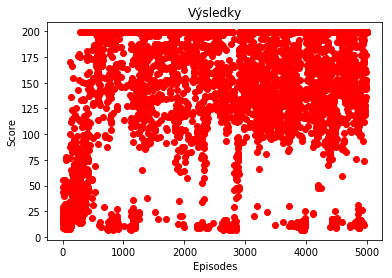

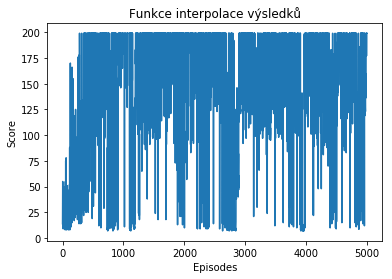

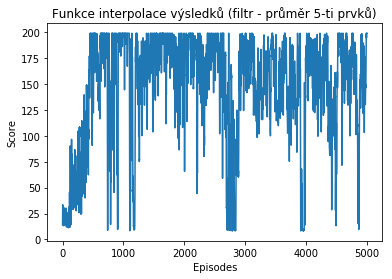

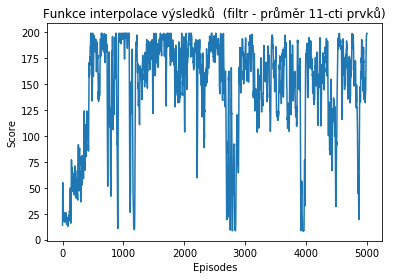

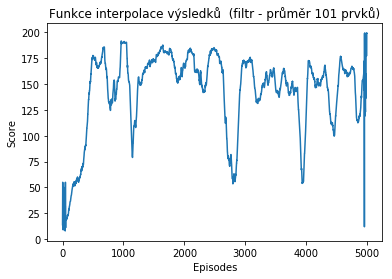

In [21]:
%matplotlib inline  
import matplotlib.pyplot as plt
import copy

score1 = copy.copy(scores)
score2 = copy.copy(scores)
score3 = copy.copy(scores)

for i in range (len(scores)):
    if i > 1 and i < (len(scores)-2):
        score1[i] = (scores[i - 2] + scores[i - 1] + scores[i] + scores[i + 1] + scores[i + 2])/5
        
for i in range (len(scores)):
    if i > 4 and i < (len(scores)-5):
        score2[i] += scores[i - 5] + scores[i - 4] + scores[i - 3] + scores[i - 2] + scores[i - 1]
        score2[i] += scores[i + 5] + scores[i + 4] + scores[i + 3] + scores[i + 2] + scores[i + 1]
        score2[i] = score2[i]/11

for i in range (len(scores)):
    if i > 49 and i < (len(scores) - 50):
        for e in range (1,50):
            score3[i] += scores[i - e] + scores[i + e] 
        score3[i] = score3[i]/101      

plt.plot(episodesList, scores, 'ro')
plt.ylabel("Score")
plt.xlabel("Episodes")
plt.title("Výsledky")
plt.show()

plt.plot(scores)
plt.ylabel("Score")
plt.xlabel("Episodes")
plt.title("Funkce interpolace výsledků")
plt.show()

plt.plot(score1)
plt.ylabel("Score")
plt.xlabel("Episodes")
plt.title("Funkce interpolace výsledků (filtr - průměr 5-ti prvků)")
plt.show()

plt.plot(score2)
plt.ylabel("Score")
plt.xlabel("Episodes")
plt.title("Funkce interpolace výsledků  (filtr - průměr 11-cti prvků)")
plt.show()

plt.plot(score3)
plt.ylabel("Score")
plt.xlabel("Episodes")
plt.title("Funkce interpolace výsledků  (filtr - průměr 101 prvků)")
plt.show()

saveDQN(net, "./DQN-CartPole-v0.h5")

# Hra

In [23]:
netForPlay = getDQN(actionCount, stateSize)
loadDQN(netForPlay, "./DQN-CartPole-v0.h5")
observation = env.reset()

for i in range (100):
    state = env.reset()
    state = np.reshape(state, [1, stateSize])
    
    total_reward = 0
    done = False
    
    while not done:
        #env.render()
        Q = netForPlay.predict(state)   
        action = np.argmax(Q)  
        observation_new, reward, done, info = env.step(int(action))

        next_state = np.reshape(observation_new, [1, stateSize])
        state = next_state

        total_reward += reward

    print('{}. Game - score: {}'.format(i, total_reward))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 24)                120       
_________________________________________________________________
dense_41 (Dense)             (None, 24)                600       
_________________________________________________________________
dense_42 (Dense)             (None, 2)                 50        
Total params: 770.0
Trainable params: 770
Non-trainable params: 0.0
_________________________________________________________________
0. Game - score: 200.0
1. Game - score: 200.0
2. Game - score: 200.0
3. Game - score: 200.0
4. Game - score: 200.0
5. Game - score: 200.0
6. Game - score: 200.0
7. Game - score: 200.0
8. Game - score: 200.0
9. Game - score: 200.0
10. Game - score: 200.0
11. Game - score: 200.0
12. Game - score: 200.0
13. Game - score: 200.0
14. Game - score: 200.0
15. Game - score: 200.0
16. Game - score: 200.0
17. Ga